## Graduation Research 

In [2]:
import tensorflow as tf
from sklearn import cross_validation
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
from keras.preprocessing import image
import keras

import random as rn
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import model_from_json
from keras.applications.vgg16 import VGG16, preprocess_input 
#https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras                                                                                                            

from PIL import Image
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from sklearn.decomposition import RandomizedPCA
from sklearn.externals import joblib
from sklearn.svm import LinearSVC

from PIL import ImageFile
import math

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


## 1枚の画像に対しPCA

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

config = tf.ConfigProto(device_count={'GPU':1,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(0)

input_shape = (300, 300, 3)
batch_size = 4
epochs = 10
num_classes = 2

f_log = './logs'
f_model = './model'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'


def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(row[1])

    label = []
    for i in labels:
        label.append(int(i))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化
    x /= 255
    y = np.asarray(label)
    y = keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []

    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(row[1])

    label1 = []
    for i in labels1:
        label1.append(int(i))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化
    test_data /= 255
    test_label = np.asarray(label1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)

    return train_data, test_data, train_label, test_label, valid_data, valid_label



# parse image
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)

    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)


# 1次元に引き延ばす(PCAで使用)
def flatten_image(img):

    s = img.shape[0] * img.shape[1] * img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(intermediate_output, y_test):
    images = intermediate_output
    labels = y_test
    ls = []

    for i in labels:
        if i == 1:
            ls.append("cloudy_seesaa")
        elif i == 0:
            ls.append("sunny_seesaa")
    labels = ls

    data = []
    for image in images:
        img = flatten_image(image)
        data.append(img)

    data = np.array(data)

    is_train = np.random.uniform(0, 1, len(data)) <= 0.7
    y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

    train_x, train_y = data[is_train], y[is_train]

    # plot in 2 dimensions
    pca = RandomizedPCA(n_components=2)
    X = pca.fit_transform(data)
    df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                       "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
    colors = ['blue', 'red']

    plt.figure(figsize=(10, 10))
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸
    plt.legend()
    #plt.show()
    plt.savefig('pca_feature1.png')

    # training a classifier
    pca = RandomizedPCA(n_components=5)
    train_x = pca.fit_transform(train_x)

    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))


def main():

    x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
                                                                           "path_and_label_test.txt")

    old_session = KTF.get_session()

    with tf.Graph().as_default():

        session = tf.Session('')
        KTF.set_session(session)
        KTF.set_learning_phase(1)

        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=input_shape, kernel_initializer="he_normal",
                         bias_initializer="zeros"))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(28, activation='relu', init="he_uniform"))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax')) # num_classes = 2値分類


        """
        # load trained model
        json_string = open(os.path.join(f_model, model_filename)).read()
        model = model_from_json(json_string)
        model.load_weights(os.path.join(f_model, weights_filename))
        """
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer="SGD",
                      metrics=['accuracy'])

        print(model.summary())

        # callback function
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)
        cbks = [tb_cb]

        # train
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,       #進行状況の表示モード
                            callbacks=cbks,  # [plot_losses, csv_logger],
                            validation_data=(x_test, y_test))
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=4) 
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=4)
        print('Train loss: {0}'.format(score_train[0]))
        print('Train accuracy: {0}'.format(score_train[1]))
        print('Test loss: {0}'.format(score_test[0]))
        print('Test accuracy: {0}'.format(score_test[1]))
        
        # 学習済みモデル書き出し
        json_string = model.to_json()
        open(os.path.join(f_model, 'cnn_model.json'), 'w').write(json_string)
        yaml_string = model.to_yaml()
        open(os.path.join(f_model, 'cnn_model.yaml'), 'w').write(yaml_string)
        print('save weights')
        model.save_weights(os.path.join(f_model, 'cnn_model_weights.hdf5'))

        # modelのlayer_nameを調べる
        for layer in model.layers:
            print(layer.name)

        layer_name ="conv2d_2"#"dropout_1"#"conv2d_2"# "max_pooling2d_1"
        intermediate_layer_model = keras.models.Model(inputs=model.input,
                                                      outputs=model.get_layer(layer_name).output)
       
        layers = model.layers[1:2]#[3:4]#[1:2]#[2:3]
        img = image.load_img("/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0064.jpg", target_size=(300, 300))
        img = image.img_to_array(img)
        img /= 255
        img = np.expand_dims(img, axis=0)
        # 指定したlayer_nameと一致するレイヤーの出力を取得する
        activations = intermediate_layer_model.predict(img)
        activations = [activation for layer, activation in zip(layers, activations) if isinstance(layer, Conv2D)]
        print(activations)
        # 単品の特徴画像生成#
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            max = np.max(activation[0])
            for j in range(0, num_of_image):
                plt.figure(figsize=(50, 50))
                sns.heatmap(activation[:, :,j], vmin=0, vmax=max, xticklabels=False, yticklabels=False, square=False)
                plt.savefig("%d_%d.png" % (i+1, j+1))
                plt.close()
        # 出力層ごとに特徴画像を並べてヒートマップ画像として出力
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            cols = math.ceil(math.sqrt(num_of_image))
            rows = math.floor(num_of_image / cols)
            screen = []
            for y in range(0, rows):
                row = []
                for x in range(0, cols):
                    j = y * cols + x
                    if j < num_of_image:
                        row.append(activation[:, :, j])
                    else:
                        row.append(np.zeros())
                screen.append(np.concatenate(row, axis=1))
            screen = np.concatenate(screen, axis=0)
            plt.figure(figsize=(50, 50))
            sns.heatmap(screen, xticklabels=False, yticklabels=False)
            name = "maxpooling2d"
            plt.savefig("%s.png" % name)
            plt.close()
       
        #handle_image_with_pca(activations, np.zeros(1))


    

    # add for TeonsorBoard

    KTF.set_session(old_session)
    
if __name__ == '__main__':
    main()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 296, 296, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 148, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 148, 148, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1401856)           0         
_______________________________________________________

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:189: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(28, kernel_initializer="he_uniform", activation="relu")`


Train on 392 samples, validate on 354 samples
Epoch 1/10
392/392 [==============================] - 114s - loss: 0.9597 - acc: 0.7372 - val_loss: 0.5012 - val_acc: 0.7740
Epoch 2/10
392/392 [==============================] - 115s - loss: 0.2490 - acc: 0.9362 - val_loss: 0.5130 - val_acc: 0.7542
Epoch 3/10
392/392 [==============================] - 116s - loss: 0.0469 - acc: 0.9974 - val_loss: 0.2822 - val_acc: 0.8475
Epoch 4/10
392/392 [==============================] - 116s - loss: 0.0352 - acc: 1.0000 - val_loss: 0.1266 - val_acc: 0.9576
Epoch 5/10
392/392 [==============================] - 119s - loss: 0.0252 - acc: 0.9923 - val_loss: 0.5630 - val_acc: 0.7881
Epoch 6/10
392/392 [==============================] - 114s - loss: 0.0328 - acc: 0.9872 - val_loss: 0.1921 - val_acc: 0.9322
Epoch 7/10
392/392 [==============================] - 118s - loss: 0.0189 - acc: 0.9974 - val_loss: 0.2090 - val_acc: 0.9124
Epoch 8/10
392/392 [==============================] - 118s - loss: 0.0090 - acc

## 2枚の画像に対しPCA

## Conv2D_1

(392, 300, 300, 3)
(392, 2)
conv2d_1
conv2d_2
max_pooling2d_1
dropout_1
flatten_1
dense_1
dropout_2
dense_2
(1, 298, 298, 32)
(1, 298, 298, 32)
(2, 298, 298, 32)
[[[2.96270996e-02 7.00278580e-02 1.68809015e-02 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [2.22702324e-03 0.00000000e+00 1.31465113e-02 ... 0.00000000e+00
   0.00000000e+00 4.43062335e-02]
  [2.90509760e-02 1.89161301e-03 5.01074195e-02 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [1.28399968e-01 2.73217499e-01 5.68576455e-01 ... 2.50554197e-02
   0.00000000e+00 1.18384928e-01]
  [1.27263516e-01 2.66377985e-01 5.75790286e-01 ... 2.52576284e-02
   0.00000000e+00 1.22211993e-01]
  [1.37739688e-01 2.68618703e-01 5.77353895e-01 ... 3.23329680e-02
   0.00000000e+00 1.22571543e-01]]

 [[1.93517245e-02 7.65477121e-03 6.47983178e-02 ... 0.00000000e+00
   0.00000000e+00 1.86462421e-02]
  [2.00570747e-02 3.02221477e-02 8.88440832e-02 ... 0.00000000e+00
   0.00000000e+00 3.71262059e-02]
  [1.24083571e-02 3.00

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


[[[0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]
  [0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]
  [0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]
  ...
  [0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]
  [0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]
  [0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]]

 [[0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]
  [0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]
  [0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]
  ...
  [0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]
  [0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]
  [0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]]

 [[0.         0.         0.00151885 ... 0.00249312 0.04058905 0.        ]
  [0.         0.      

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


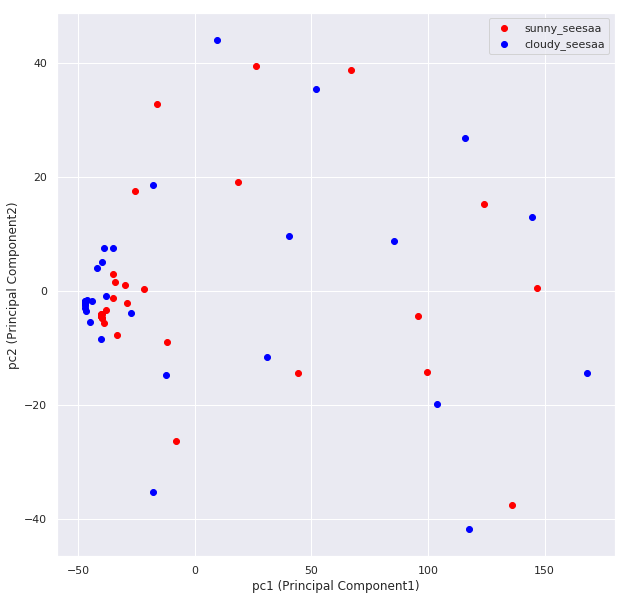

In [16]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

config = tf.ConfigProto(device_count={'GPU':1,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)                              
tf.set_random_seed(0)

input_shape = (300, 300, 3)
batch_size = 4
epochs = 10
num_classes = 2

f_log = './logs'
f_model = './model'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'

def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(row[1])

    label = []
    for i in labels:
        label.append(int(i))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化                                                                                                                 
    x /= 255
    y = np.asarray(label)
    y = keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []
    
    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(row[1])

    label1 = []
    for i in labels1:
        label1.append(int(i))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化                                                                                                                
    test_data /= 255
    test_label = np.asarray(label1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)
    
    print(np.shape(train_data))
    print(np.shape(train_label))
    return train_data, test_data, train_label, test_label, valid_data, valid_label



# parse image                                                                                                               
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)                                                                     


# 1次元に引き延ばす(PCAで使用)                                                                                              
def flatten_image(img):

    s = img.shape[0] * img.shape[1] #* img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(activations, y_test):

    for i in range(2):
        images = activations[i,:,:,:]
        print(images)
        if i == 0:
            labels = y_test[:32]
        elif i == 1:
            labels = y_test[32:]
        ls = []

        for label in labels:

            if list(label) == [0,1]:
                ls.append("cloudy_seesaa")
            elif list(label) == [1,0]:
                ls.append("sunny_seesaa")
        labels = ls
        print(labels)
        data = []
        for a in range(32):#for image in images:
            img = flatten_image(images[:, :, a])
            data.append(img)

        data = np.array(data)

        is_train = np.random.uniform(0, 1, len(data)) <= 0.7
        y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

        train_x, train_y = data[is_train], y[is_train]

        pca = RandomizedPCA(n_components=2)
        X = pca.fit_transform(data)
        if i == 0:
            df1 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
        elif i == 1:
            df2 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
            df = pd.concat([df1, df2])
    colors = ['red','blue']

    plt.figure(figsize=(10, 10))
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向                                              
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸                                                  
    plt.legend()
    #plt.show()                                                                                                             
    plt.savefig('pca_feature1.png')

    # training a classifier                                                                                                 
    pca = RandomizedPCA(n_components=2)
    train_x = pca.fit_transform(train_x)
    """
    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model                                                                                                  
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))
    """
def main():

    x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
                                                                           "path_and_label_test.txt")

    old_session = KTF.get_session()

    with tf.Graph().as_default():

        session = tf.Session('')
        KTF.set_session(session)
        KTF.set_learning_phase(1)
        """
        model = Sequential()                                                                                                
        model.add(Conv2D(32, kernel_size=(3, 3),                                                                            
                         activation='relu',                                                                                 
                         input_shape=input_shape, kernel_initializer="he_normal",                        
                         bias_initializer="zeros"))                                                                         
        model.add(Conv2D(64, (3, 3), activation='relu'))                                                                    
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))                                                                                            
        model.add(Flatten())                                                                                                
        model.add(Dense(28, activation='relu', init='he_uniform'))                                                          
        model.add(Dropout(0.5))                                                                                             
        model.add(Dense(num_classes, activation='softmax')) # num_classes = 2値分類                                         
                                                                                                                            
                                                                                                                            
        """
       # load trained model                                                                                                
        json_string = open(os.path.join(f_model, model_filename)).read()
        model = model_from_json(json_string)
        model.load_weights(os.path.join(f_model, weights_filename))
        """                                                                                                                 
        model.compile(loss=keras.losses.categorical_crossentropy,                                                           
                      optimizer="SGD",                                                                                      
                      metrics=['accuracy'])                                                                                 
                                                                                                                            
        print(model.summary())                                                                                              
                                                                                                                            
        # callback function                                                                                                 
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)                                                
        cbks = [tb_cb]                                                                                                      
                                                                                                                            
        # train                                                                                                             
        history = model.fit(x_train, y_train,                                                                               
                            batch_size=batch_size,                                                                          
                            epochs=epochs,                                                                                  
                            verbose=1,       #進行状況の表示モード                                                          
                            callbacks=cbks,  # [plot_losses, csv_logger],                                                   
                            validation_data=(x_test, y_test))                                                               
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=4)                                              
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=4)                                                
        print('Train loss: {0}'.format(score_train[0]))                                                                     
        print('Train accuracy: {0}'.format(score_train[1]))                                                                 
        print('Test loss: {0}'.format(score_test[0]))                                                                       
        print('Test accuracy: {0}'.format(score_test[1]))                                                                   
                                                                                                                            
        # 学習済みモデル書き出し                                                                                            
        json_string = model.to_json()                                                                                       
        open(os.path.join(f_model, 'cnn_model.json'), 'w').write(json_string)                                               
        yaml_string = model.to_yaml()                                                                                       
        open(os.path.join(f_model, 'cnn_model.yaml'), 'w').write(yaml_string)                                               
        print('save weights')                                                                                               
        model.save_weights(os.path.join(f_model, 'cnn_model_weights.hdf5'))                                                 
        """
       # modelのlayer_nameを調べる                                                                                                                         
        for layer in model.layers:
            print(layer.name)

        layer_name ="conv2d_1"# "max_pooling2d_1"                                                                                    
        intermediate_layer_model = keras.models.Model(inputs=model.input,
                                         outputs=model.get_layer(layer_name).output)


        layers = model.layers[0:1]     
        
        urls = ["/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0104.jpg", 
        "/home/seimei/Graduation_Research/dataset_valid/kumori/class4-5/image_0064.jpg"]

        activations = np.zeros((0,298,298,32))
        for url in urls:
            img = image.load_img(url, target_size=(300, 300))
            img = image.img_to_array(img)
            img /= 255
            img = np.expand_dims(img, axis=0)
            # 指定したlayer_nameと一致するレイヤーの出力を取得する                                                                                              
            _activations = intermediate_layer_model.predict(img)
            _activations = [activation for layer, activation in zip(layers, _activations) if isinstance(layer, Conv2D)]
            print(np.shape(_activations))
            activations = np.r_[activations, np.reshape(_activations,(-1,298,298,32))]
        print(np.shape(activations))
        """
        # 単品の特徴画像生成#                                                                                                                               
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            max = np.max(activation[0])
            for j in range(0, num_of_image):
                plt.figure(figsize=(50, 50))
                sns.heatmap(activation[:, :,j], vmin=0, vmax=max, xticklabels=False, yticklabels=False, square=False)
                plt.savefig("%d_%d.png" % (i+1, j+1))
                plt.close()
        # 出力層ごとに特徴画像を並べてヒートマップ画像として出力                                                                                            
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            cols = math.ceil(math.sqrt(num_of_image))
            rows = math.floor(num_of_image / cols)
            screen = []
            for y in range(0, rows):
                row = []
                for x in range(0, cols):
                    j = y * cols + x
                    if j < num_of_image:
                        row.append(activation[:, :, j])
                    else:
                        row.append(np.zeros())
                screen.append(np.concatenate(row, axis=1))
            screen = np.concatenate(screen, axis=0)
            plt.figure(figsize=(50, 50))
            sns.heatmap(screen, xticklabels=False, yticklabels=False)
            name = "maxpooling2d"
            plt.savefig("%s.png" % name)
            plt.close()
        """
        y = keras.utils.to_categorical(np.r_[np.zeros(32), np.ones(32)], num_classes)

        handle_image_with_pca(activations, y )
        



    # add for TeonsorBoard                                                                                                                                  

    KTF.set_session(old_session)

if __name__ == '__main__':
    main()

## Conv2D_2

(392, 300, 300, 3)
(392, 2)
conv2d_1
conv2d_2
max_pooling2d_1
dropout_1
flatten_1
dense_1
dropout_2
dense_2
(1, 296, 296, 64)
(1, 296, 296, 64)
(2, 296, 296, 64)
[[[0.06082237 0.         0.         ... 0.02744044 0.02576346 0.        ]
  [0.06933381 0.         0.         ... 0.01179278 0.03821193 0.        ]
  [0.07889335 0.         0.         ... 0.00461735 0.04573893 0.        ]
  ...
  [0.         0.         0.         ... 0.         0.03775717 0.        ]
  [0.         0.         0.         ... 0.         0.03948865 0.        ]
  [0.         0.         0.         ... 0.         0.04759868 0.        ]]

 [[0.         0.         0.         ... 0.01722984 0.06238442 0.        ]
  [0.         0.         0.         ... 0.01817362 0.05470132 0.        ]
  [0.         0.         0.         ... 0.0028831  0.05812925 0.        ]
  ...
  [0.         0.         0.         ... 0.         0.04311202 0.        ]
  [0.         0.         0.         ... 0.         0.04232234 0.        ]
  [0.     

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


[[[0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]
  [0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]
  [0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]
  ...
  [0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]
  [0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]
  [0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]]

 [[0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]
  [0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]
  [0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]
  ...
  [0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]
  [0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]
  [0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]]

 [[0.04170053 0.02178704 0.         ... 0.01822897 0.04629833 0.        ]
  [0.04170053 0.021787

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


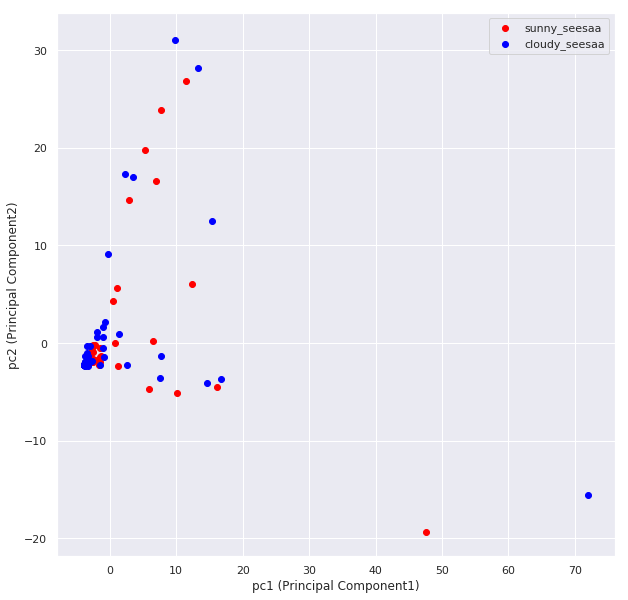

In [17]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

config = tf.ConfigProto(device_count={'GPU':1,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)                              
tf.set_random_seed(0)

input_shape = (300, 300, 3)
batch_size = 4
epochs = 10
num_classes = 2

f_log = './logs'
f_model = './model'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'

def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(row[1])

    label = []
    for i in labels:
        label.append(int(i))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化                                                                                                                 
    x /= 255
    y = np.asarray(label)
    y = keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []
    
    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(row[1])

    label1 = []
    for i in labels1:
        label1.append(int(i))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化                                                                                                                
    test_data /= 255
    test_label = np.asarray(label1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)
    
    print(np.shape(train_data))
    print(np.shape(train_label))
    return train_data, test_data, train_label, test_label, valid_data, valid_label



# parse image                                                                                                               
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)                                                                     


# 1次元に引き延ばす(PCAで使用)                                                                                              
def flatten_image(img):

    s = img.shape[0] * img.shape[1] #* img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(activations, y_test):

    for i in range(2):
        images = activations[i,:,:,:]
        print(images)
        if i == 0:
            labels = y_test[:64]
        elif i == 1:
            labels = y_test[64:]
        ls = []

        for label in labels:

            if list(label) == [0,1]:
                ls.append("cloudy_seesaa")
            elif list(label) == [1,0]:
                ls.append("sunny_seesaa")
        labels = ls
        print(labels)
        data = []
        for a in range(64):#for image in images:
            img = flatten_image(images[:, :, a])
            data.append(img)

        data = np.array(data)

        is_train = np.random.uniform(0, 1, len(data)) <= 0.7
        y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

        train_x, train_y = data[is_train], y[is_train]

        pca = RandomizedPCA(n_components=2)
        X = pca.fit_transform(data)
        if i == 0:
            df1 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
        elif i == 1:
            df2 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
            df = pd.concat([df1, df2])
    colors = ['red','blue']

    plt.figure(figsize=(10, 10))
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向                                              
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸                                                  
    plt.legend()
    #plt.show()                                                                                                             
    plt.savefig('pca_feature1.png')

    # training a classifier                                                                                                 
    pca = RandomizedPCA(n_components=2)
    train_x = pca.fit_transform(train_x)
    """
    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model                                                                                                  
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))
    """
def main():

    x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
                                                                           "path_and_label_test.txt")

    old_session = KTF.get_session()

    with tf.Graph().as_default():

        session = tf.Session('')
        KTF.set_session(session)
        KTF.set_learning_phase(1)
        """
        model = Sequential()                                                                                                
        model.add(Conv2D(32, kernel_size=(3, 3),                                                                            
                         activation='relu',                                                                                 
                         input_shape=input_shape, kernel_initializer="he_normal",                        
                         bias_initializer="zeros"))                                                                         
        model.add(Conv2D(64, (3, 3), activation='relu'))                                                                    
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))                                                                                            
        model.add(Flatten())                                                                                                
        model.add(Dense(28, activation='relu', init='he_uniform'))                                                          
        model.add(Dropout(0.5))                                                                                             
        model.add(Dense(num_classes, activation='softmax')) # num_classes = 2値分類                                         
                                                                                                                            
                                                                                                                            
        """
       # load trained model                                                                                                
        json_string = open(os.path.join(f_model, model_filename)).read()
        model = model_from_json(json_string)
        model.load_weights(os.path.join(f_model, weights_filename))
        """                                                                                                                 
        model.compile(loss=keras.losses.categorical_crossentropy,                                                           
                      optimizer="SGD",                                                                                      
                      metrics=['accuracy'])                                                                                 
                                                                                                                            
        print(model.summary())                                                                                              
                                                                                                                            
        # callback function                                                                                                 
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)                                                
        cbks = [tb_cb]                                                                                                      
                                                                                                                            
        # train                                                                                                             
        history = model.fit(x_train, y_train,                                                                               
                            batch_size=batch_size,                                                                          
                            epochs=epochs,                                                                                  
                            verbose=1,       #進行状況の表示モード                                                          
                            callbacks=cbks,  # [plot_losses, csv_logger],                                                   
                            validation_data=(x_test, y_test))                                                               
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=4)                                              
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=4)                                                
        print('Train loss: {0}'.format(score_train[0]))                                                                     
        print('Train accuracy: {0}'.format(score_train[1]))                                                                 
        print('Test loss: {0}'.format(score_test[0]))                                                                       
        print('Test accuracy: {0}'.format(score_test[1]))                                                                   
                                                                                                                            
        # 学習済みモデル書き出し                                                                                            
        json_string = model.to_json()                                                                                       
        open(os.path.join(f_model, 'cnn_model.json'), 'w').write(json_string)                                               
        yaml_string = model.to_yaml()                                                                                       
        open(os.path.join(f_model, 'cnn_model.yaml'), 'w').write(yaml_string)                                               
        print('save weights')                                                                                               
        model.save_weights(os.path.join(f_model, 'cnn_model_weights.hdf5'))                                                 
        """
       # modelのlayer_nameを調べる                                                                                                                         
        for layer in model.layers:
            print(layer.name)

        layer_name ="conv2d_2"# "max_pooling2d_1"                                                                                    
        intermediate_layer_model = keras.models.Model(inputs=model.input,
                                         outputs=model.get_layer(layer_name).output)


        layers = model.layers[1:2]     
        
        urls = ["/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0104.jpg", 
        "/home/seimei/Graduation_Research/dataset_valid/kumori/class4-5/image_0064.jpg"]

        activations = np.zeros((0,296,296,64))
        for url in urls:
            img = image.load_img(url, target_size=(300, 300))
            img = image.img_to_array(img)
            img /= 255
            img = np.expand_dims(img, axis=0)
            # 指定したlayer_nameと一致するレイヤーの出力を取得する                                                                                              
            _activations = intermediate_layer_model.predict(img)
            _activations = [activation for layer, activation in zip(layers, _activations) if isinstance(layer, Conv2D)]
            print(np.shape(_activations))
            activations = np.r_[activations, np.reshape(_activations,(-1,296,296,64))]
        print(np.shape(activations))
        """
        # 単品の特徴画像生成#                                                                                                                               
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            max = np.max(activation[0])
            for j in range(0, num_of_image):
                plt.figure(figsize=(50, 50))
                sns.heatmap(activation[:, :,j], vmin=0, vmax=max, xticklabels=False, yticklabels=False, square=False)
                plt.savefig("%d_%d.png" % (i+1, j+1))
                plt.close()
        # 出力層ごとに特徴画像を並べてヒートマップ画像として出力                                                                                            
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            cols = math.ceil(math.sqrt(num_of_image))
            rows = math.floor(num_of_image / cols)
            screen = []
            for y in range(0, rows):
                row = []
                for x in range(0, cols):
                    j = y * cols + x
                    if j < num_of_image:
                        row.append(activation[:, :, j])
                    else:
                        row.append(np.zeros())
                screen.append(np.concatenate(row, axis=1))
            screen = np.concatenate(screen, axis=0)
            plt.figure(figsize=(50, 50))
            sns.heatmap(screen, xticklabels=False, yticklabels=False)
            name = "maxpooling2d"
            plt.savefig("%s.png" % name)
            plt.close()
        """
        y = keras.utils.to_categorical(np.r_[np.zeros(64), np.ones(64)], num_classes)

        handle_image_with_pca(activations, y )
        



    # add for TeonsorBoard                                                                                                                                  

    KTF.set_session(old_session)

if __name__ == '__main__':
    main()

## MaxPooling2D

(392, 300, 300, 3)
(392, 2)
conv2d_1
conv2d_2
max_pooling2d_1
dropout_1
flatten_1
dense_1
dropout_2
dense_2
(1, 148, 148, 64)
(1, 148, 148, 64)
(2, 148, 148, 64)
[[[6.93338141e-02 0.00000000e+00 0.00000000e+00 ... 2.74404436e-02
   6.23844229e-02 0.00000000e+00]
  [7.88933486e-02 0.00000000e+00 0.00000000e+00 ... 4.61735018e-03
   7.02448860e-02 0.00000000e+00]
  [6.46874681e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   8.74639973e-02 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   4.18096334e-02 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   4.31120172e-02 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   4.75986823e-02 0.00000000e+00]]

 [[3.24257165e-02 0.00000000e+00 0.00000000e+00 ... 4.45928052e-03
   9.05821770e-02 0.00000000e+00]
  [4.98025492e-03 0.00000000e+00 0.00000000e+00 ... 1.73317268e-03
   5.29953390e-02 0.00000000e+00]
  [2.56807059e-02 0.00

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated

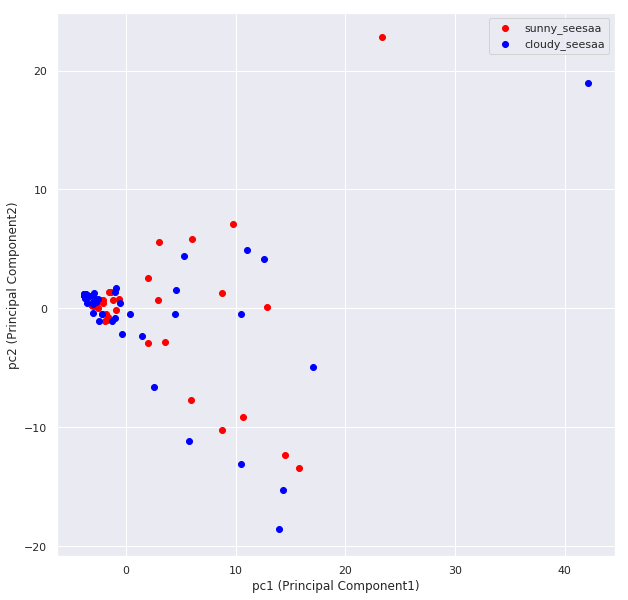

In [18]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

config = tf.ConfigProto(device_count={'GPU':1,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)                              
tf.set_random_seed(0)

input_shape = (300, 300, 3)
batch_size = 4
epochs = 10
num_classes = 2

f_log = './logs'
f_model = './model'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'

def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(row[1])

    label = []
    for i in labels:
        label.append(int(i))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化                                                                                                                 
    x /= 255
    y = np.asarray(label)
    y = keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []
    
    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(row[1])

    label1 = []
    for i in labels1:
        label1.append(int(i))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化                                                                                                                
    test_data /= 255
    test_label = np.asarray(label1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)
    
    print(np.shape(train_data))
    print(np.shape(train_label))
    return train_data, test_data, train_label, test_label, valid_data, valid_label



# parse image                                                                                                               
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)                                                                     


# 1次元に引き延ばす(PCAで使用)                                                                                              
def flatten_image(img):

    s = img.shape[0] * img.shape[1] #* img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(activations, y_test):

    for i in range(2):
        images = activations[i,:,:,:]
        print(images)
        if i == 0:
            labels = y_test[:64]
        elif i == 1:
            labels = y_test[64:]
        ls = []

        for label in labels:

            if list(label) == [0,1]:
                ls.append("cloudy_seesaa")
            elif list(label) == [1,0]:
                ls.append("sunny_seesaa")
        labels = ls
        print(labels)
        data = []
        for a in range(64):#for image in images:
            img = flatten_image(images[:, :, a])
            data.append(img)

        data = np.array(data)

        is_train = np.random.uniform(0, 1, len(data)) <= 0.7
        y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

        train_x, train_y = data[is_train], y[is_train]

        pca = RandomizedPCA(n_components=2)
        X = pca.fit_transform(data)
        if i == 0:
            df1 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
        elif i == 1:
            df2 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
            df = pd.concat([df1, df2])
    colors = ['red','blue']

    plt.figure(figsize=(10, 10))
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向                                              
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸                                                  
    plt.legend()
    #plt.show()                                                                                                             
    plt.savefig('pca_feature1.png')

    # training a classifier                                                                                                 
    pca = RandomizedPCA(n_components=2)
    train_x = pca.fit_transform(train_x)
    """
    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model                                                                                                  
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))
    """
def main():

    x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
                                                                           "path_and_label_test.txt")

    old_session = KTF.get_session()

    with tf.Graph().as_default():

        session = tf.Session('')
        KTF.set_session(session)
        KTF.set_learning_phase(1)
        """
        model = Sequential()                                                                                                
        model.add(Conv2D(32, kernel_size=(3, 3),                                                                            
                         activation='relu',                                                                                 
                         input_shape=input_shape, kernel_initializer="he_normal",                        
                         bias_initializer="zeros"))                                                                         
        model.add(Conv2D(64, (3, 3), activation='relu'))                                                                    
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))                                                                                            
        model.add(Flatten())                                                                                                
        model.add(Dense(28, activation='relu', init='he_uniform'))                                                          
        model.add(Dropout(0.5))                                                                                             
        model.add(Dense(num_classes, activation='softmax')) # num_classes = 2値分類                                         
                                                                                                                            
                                                                                                                            
        """
       # load trained model                                                                                                
        json_string = open(os.path.join(f_model, model_filename)).read()
        model = model_from_json(json_string)
        model.load_weights(os.path.join(f_model, weights_filename))
        """                                                                                                                 
        model.compile(loss=keras.losses.categorical_crossentropy,                                                           
                      optimizer="SGD",                                                                                      
                      metrics=['accuracy'])                                                                                 
                                                                                                                            
        print(model.summary())                                                                                              
                                                                                                                            
        # callback function                                                                                                 
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)                                                
        cbks = [tb_cb]                                                                                                      
                                                                                                                            
        # train                                                                                                             
        history = model.fit(x_train, y_train,                                                                               
                            batch_size=batch_size,                                                                          
                            epochs=epochs,                                                                                  
                            verbose=1,       #進行状況の表示モード                                                          
                            callbacks=cbks,  # [plot_losses, csv_logger],                                                   
                            validation_data=(x_test, y_test))                                                               
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=4)                                              
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=4)                                                
        print('Train loss: {0}'.format(score_train[0]))                                                                     
        print('Train accuracy: {0}'.format(score_train[1]))                                                                 
        print('Test loss: {0}'.format(score_test[0]))                                                                       
        print('Test accuracy: {0}'.format(score_test[1]))                                                                   
                                                                                                                            
        # 学習済みモデル書き出し                                                                                            
        json_string = model.to_json()                                                                                       
        open(os.path.join(f_model, 'cnn_model.json'), 'w').write(json_string)                                               
        yaml_string = model.to_yaml()                                                                                       
        open(os.path.join(f_model, 'cnn_model.yaml'), 'w').write(yaml_string)                                               
        print('save weights')                                                                                               
        model.save_weights(os.path.join(f_model, 'cnn_model_weights.hdf5'))                                                 
        """
       # modelのlayer_nameを調べる                                                                                                                         
        for layer in model.layers:
            print(layer.name)

        layer_name ="max_pooling2d_1"#"conv2d_2"# "max_pooling2d_1"                                                                                    
        intermediate_layer_model = keras.models.Model(inputs=model.input,
                                         outputs=model.get_layer(layer_name).output)


        layers = model.layers[2:3]     
        
        urls = ["/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0104.jpg", 
        "/home/seimei/Graduation_Research/dataset_valid/kumori/class4-5/image_0064.jpg"]

        activations = np.zeros((0,148,148,64))
        for url in urls:
            img = image.load_img(url, target_size=(300, 300))
            img = image.img_to_array(img)
            img /= 255
            img = np.expand_dims(img, axis=0)
            # 指定したlayer_nameと一致するレイヤーの出力を取得する                                                                                              
            _activations = intermediate_layer_model.predict(img)
            _activations = [activation for layer, activation in zip(layers, _activations) if isinstance(layer, MaxPooling2D)]
            print(np.shape(_activations))
            activations = np.r_[activations, np.reshape(_activations,(-1,148,148,64))]
        print(np.shape(activations))
        """
        # 単品の特徴画像生成#                                                                                                                               
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            max = np.max(activation[0])
            for j in range(0, num_of_image):
                plt.figure(figsize=(50, 50))
                sns.heatmap(activation[:, :,j], vmin=0, vmax=max, xticklabels=False, yticklabels=False, square=False)
                plt.savefig("%d_%d.png" % (i+1, j+1))
                plt.close()
        # 出力層ごとに特徴画像を並べてヒートマップ画像として出力                                                                                            
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            cols = math.ceil(math.sqrt(num_of_image))
            rows = math.floor(num_of_image / cols)
            screen = []
            for y in range(0, rows):
                row = []
                for x in range(0, cols):
                    j = y * cols + x
                    if j < num_of_image:
                        row.append(activation[:, :, j])
                    else:
                        row.append(np.zeros())
                screen.append(np.concatenate(row, axis=1))
            screen = np.concatenate(screen, axis=0)
            plt.figure(figsize=(50, 50))
            sns.heatmap(screen, xticklabels=False, yticklabels=False)
            name = "maxpooling2d"
            plt.savefig("%s.png" % name)
            plt.close()
        """
        y = keras.utils.to_categorical(np.r_[np.zeros(64), np.ones(64)], num_classes)

        handle_image_with_pca(activations, y )
        



    # add for TeonsorBoard                                                                                                                                  

    KTF.set_session(old_session)

if __name__ == '__main__':
    main()

# DropOut

(392, 300, 300, 3)
(392, 2)
conv2d_1
conv2d_2
max_pooling2d_1
dropout_1
flatten_1
dense_1
dropout_2
dense_2
(1, 148, 148, 64)
(1, 148, 148, 64)
(2, 148, 148, 64)
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.65872607e-02
   8.31792355e-02 0.00000000e+00]
  [1.05191134e-01 0.00000000e+00 0.00000000e+00 ... 6.15646690e-03
   0.00000000e+00 0.00000000e+00]
  [8.62499624e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   5.57461791e-02 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   5.74826896e-02 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[4.32342887e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   1.20776236e-01 0.00000000e+00]
  [6.64034020e-03 0.00000000e+00 0.00000000e+00 ... 2.31089699e-03
   7.06604570e-02 0.00000000e+00]
  [3.42409424e-02 0.00

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated

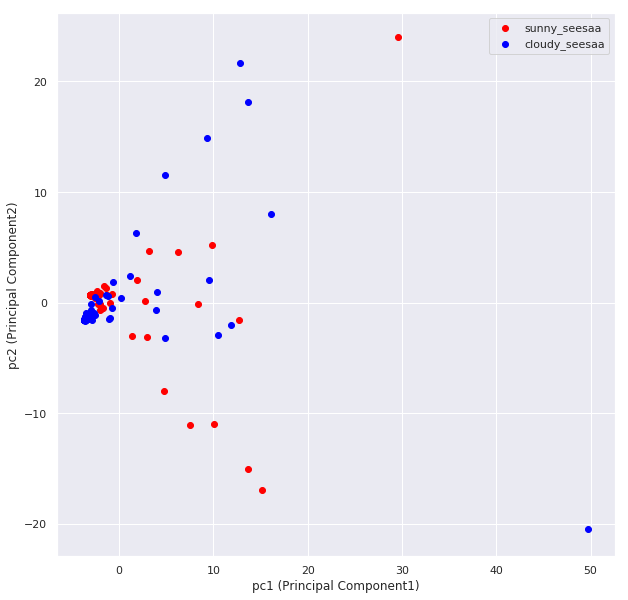

In [19]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

config = tf.ConfigProto(device_count={'GPU':1,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)                              
tf.set_random_seed(0)

input_shape = (300, 300, 3)
batch_size = 4
epochs = 10
num_classes = 2

f_log = './logs'
f_model = './model'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'

def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(row[1])

    label = []
    for i in labels:
        label.append(int(i))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化                                                                                                                 
    x /= 255
    y = np.asarray(label)
    y = keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []
    
    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(row[1])

    label1 = []
    for i in labels1:
        label1.append(int(i))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化                                                                                                                
    test_data /= 255
    test_label = np.asarray(label1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)
    
    print(np.shape(train_data))
    print(np.shape(train_label))
    return train_data, test_data, train_label, test_label, valid_data, valid_label



# parse image                                                                                                               
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)                                                                     


# 1次元に引き延ばす(PCAで使用)                                                                                              
def flatten_image(img):

    s = img.shape[0] * img.shape[1] #* img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(activations, y_test):

    for i in range(2):
        images = activations[i,:,:,:]
        print(images)
        if i == 0:
            labels = y_test[:64]
        elif i == 1:
            labels = y_test[64:]
        ls = []

        for label in labels:

            if list(label) == [0,1]:
                ls.append("cloudy_seesaa")
            elif list(label) == [1,0]:
                ls.append("sunny_seesaa")
        labels = ls
        print(labels)
        data = []
        for a in range(64):#for image in images:
            img = flatten_image(images[:, :, a])
            data.append(img)

        data = np.array(data)

        is_train = np.random.uniform(0, 1, len(data)) <= 0.7
        y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

        train_x, train_y = data[is_train], y[is_train]

        pca = RandomizedPCA(n_components=2)
        X = pca.fit_transform(data)
        if i == 0:
            df1 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
        elif i == 1:
            df2 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
            df = pd.concat([df1, df2])
    colors = ['red','blue']

    plt.figure(figsize=(10, 10))
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向                                              
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸                                                  
    plt.legend()
    #plt.show()                                                                                                             
    plt.savefig('pca_feature1.png')

    # training a classifier                                                                                                 
    pca = RandomizedPCA(n_components=2)
    train_x = pca.fit_transform(train_x)
    """
    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model                                                                                                  
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))
    """
def main():

    x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
                                                                           "path_and_label_test.txt")

    old_session = KTF.get_session()

    with tf.Graph().as_default():

        session = tf.Session('')
        KTF.set_session(session)
        KTF.set_learning_phase(1)
        """
        model = Sequential()                                                                                                
        model.add(Conv2D(32, kernel_size=(3, 3),                                                                            
                         activation='relu',                                                                                 
                         input_shape=input_shape, kernel_initializer="he_normal",                        
                         bias_initializer="zeros"))                                                                         
        model.add(Conv2D(64, (3, 3), activation='relu'))                                                                    
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))                                                                                            
        model.add(Flatten())                                                                                                
        model.add(Dense(28, activation='relu', init='he_uniform'))                                                          
        model.add(Dropout(0.5))                                                                                             
        model.add(Dense(num_classes, activation='softmax')) # num_classes = 2値分類                                         
                                                                                                                            
                                                                                                                            
        """
       # load trained model                                                                                                
        json_string = open(os.path.join(f_model, model_filename)).read()
        model = model_from_json(json_string)
        model.load_weights(os.path.join(f_model, weights_filename))
        """                                                                                                                 
        model.compile(loss=keras.losses.categorical_crossentropy,                                                           
                      optimizer="SGD",                                                                                      
                      metrics=['accuracy'])                                                                                 
                                                                                                                            
        print(model.summary())                                                                                              
                                                                                                                            
        # callback function                                                                                                 
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)                                                
        cbks = [tb_cb]                                                                                                      
                                                                                                                            
        # train                                                                                                             
        history = model.fit(x_train, y_train,                                                                               
                            batch_size=batch_size,                                                                          
                            epochs=epochs,                                                                                  
                            verbose=1,       #進行状況の表示モード                                                          
                            callbacks=cbks,  # [plot_losses, csv_logger],                                                   
                            validation_data=(x_test, y_test))                                                               
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=4)                                              
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=4)                                                
        print('Train loss: {0}'.format(score_train[0]))                                                                     
        print('Train accuracy: {0}'.format(score_train[1]))                                                                 
        print('Test loss: {0}'.format(score_test[0]))                                                                       
        print('Test accuracy: {0}'.format(score_test[1]))                                                                   
                                                                                                                            
        # 学習済みモデル書き出し                                                                                            
        json_string = model.to_json()                                                                                       
        open(os.path.join(f_model, 'cnn_model.json'), 'w').write(json_string)                                               
        yaml_string = model.to_yaml()                                                                                       
        open(os.path.join(f_model, 'cnn_model.yaml'), 'w').write(yaml_string)                                               
        print('save weights')                                                                                               
        model.save_weights(os.path.join(f_model, 'cnn_model_weights.hdf5'))                                                 
        """
       # modelのlayer_nameを調べる                                                                                                                         
        for layer in model.layers:
            print(layer.name)

        layer_name ="dropout_1"#"conv2d_2"# "max_pooling2d_1"                                                                                    
        intermediate_layer_model = keras.models.Model(inputs=model.input,
                                         outputs=model.get_layer(layer_name).output)


        layers = model.layers[3:4]     
        
        urls = ["/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0104.jpg", 
        "/home/seimei/Graduation_Research/dataset_valid/kumori/class4-5/image_0064.jpg"]

        activations = np.zeros((0,148,148,64))
        for url in urls:
            img = image.load_img(url, target_size=(300, 300))
            img = image.img_to_array(img)
            img /= 255
            img = np.expand_dims(img, axis=0)
            # 指定したlayer_nameと一致するレイヤーの出力を取得する                                                                                              
            _activations = intermediate_layer_model.predict(img)
            _activations = [activation for layer, activation in zip(layers, _activations) if isinstance(layer, Dropout)]
            print(np.shape(_activations))
            activations = np.r_[activations, np.reshape(_activations,(-1,148,148,64))]
        print(np.shape(activations))
        """
        # 単品の特徴画像生成#                                                                                                                               
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            max = np.max(activation[0])
            for j in range(0, num_of_image):
                plt.figure(figsize=(50, 50))
                sns.heatmap(activation[:, :,j], vmin=0, vmax=max, xticklabels=False, yticklabels=False, square=False)
                plt.savefig("%d_%d.png" % (i+1, j+1))
                plt.close()
        # 出力層ごとに特徴画像を並べてヒートマップ画像として出力                                                                                            
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            cols = math.ceil(math.sqrt(num_of_image))
            rows = math.floor(num_of_image / cols)
            screen = []
            for y in range(0, rows):
                row = []
                for x in range(0, cols):
                    j = y * cols + x
                    if j < num_of_image:
                        row.append(activation[:, :, j])
                    else:
                        row.append(np.zeros())
                screen.append(np.concatenate(row, axis=1))
            screen = np.concatenate(screen, axis=0)
            plt.figure(figsize=(50, 50))
            sns.heatmap(screen, xticklabels=False, yticklabels=False)
            name = "maxpooling2d"
            plt.savefig("%s.png" % name)
            plt.close()
        """
        y = keras.utils.to_categorical(np.r_[np.zeros(64), np.ones(64)], num_classes)

        handle_image_with_pca(activations, y )
        



    # add for TeonsorBoard                                                                                                                                  

    KTF.set_session(old_session)

if __name__ == '__main__':
    main()